<a href="https://colab.research.google.com/github/Tom-Doyle/ECS781P-mini-project/blob/main/ECS708P_miniproject_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECS708P mini-project submission

**Student name:** Tom Doyle

**Student ID:** 200588104

**Brief summary:** This notebook contains two parts. Part I comprises a basic solution for predicting the intonation of a short audio segment and Part II comprises a more advanced solution for predicting bingo numbers from a short audio segment. 


## Environment set up

In this section we will set up a Colab environment for the MLEnd mini-project, which we will use for both solutions. Before starting this, I already compeleted the steps below: 

1.   Go to https://drive.google.com/
2.   Create a folder named 'Data' in 'MyDrive'. On the left, click 'New' > 'Folder', enter the name 'Data', and click 'create'
3.   Open the 'Data' folder and create a folder named 'MLEnd'.
4.   Move the file 'trainingMLEnd.csv' to the newly created folder 'MyDrive/Data/MLEnd'.



In [2]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
drive.mount('/content/drive')

Mounted at /content/drive


Run the following cell to check that the MLEnd folder contains the file 'trainingMLEnd.csv':

In [3]:
path = '/content/drive/MyDrive/Data/MLEnd'
os.listdir(path)

['trainingMLEnd.csv', 'training', 'training.zip']

## Data download

In this section, we download the data needed for both solutions.

First, we define a function that allows us to download a file into a chosen location.

In [4]:
def download_url(url, save_path):
    with urllib.request.urlopen(url) as dl_file:
        with open(save_path, 'wb') as out_file:
            out_file.write(dl_file.read())

Then we download the file 'training.zip' into the folder 'MyDrive/Data/MLEnd'.

In [5]:
url  = "https://collect.qmul.ac.uk/down?t=6H8231DQL1NGDI9A/613DLM2R3OFV5EEH9INK2OG"
save_path = '/content/drive/MyDrive/Data/MLEnd/training.zip'
download_url(url, save_path)

Finally, we unzip the training file.

In [ ]:
directory_to_extract_to = '/content/drive/MyDrive/Data/MLEnd/training/'
with zipfile.ZipFile(save_path, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

We now have all the audio files in the location 'MyDrive/Data/MLEnd/training/training'. 

We can check the total number of audio files in our dataset (20,000):

In [10]:
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
len(files)

20000

Next, we load the contents of 'trainingMLEnd.csv' into a pandas DataFrame.

In [11]:
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')
labels

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


We can see that the file consists of 20k rows and 4 columns. Each row corresponds to one of the items in our dataset, and each item is described by four attributes:


1.   File ID (audio file)
2.   Numeral
3.   Participant ID
4.   Intonation

We can explore this dataset further and identify how many items we have per numeral, per individual and per intonation.

In [12]:
labels['participant'].value_counts()
labels['digit_label'].value_counts()
labels['intonation'].value_counts()

neutral     5000
question    5000
excited     5000
bored       5000
Name: intonation, dtype: int64

# Part I: Basic solution

In this section, we build a model for predicting the intonation of a short audio segment.

Audio files are complex data types. Specifically they are **discrete signals** or **time series**, consisting of values on a 1D grid. These values are known as *samples*. The **sampling frequency** is the rate at which samples in an audio file are produced.

Below, we plot one of our audio signals.


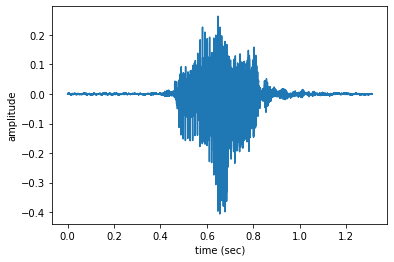

In [13]:
n=0
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

We can then look at the number of samples in one of our audio files:

In [14]:
n=0
x, fs = librosa.load(files[n],sr=fs)
print('This audio signal has', len(x), 'samples')

This audio signal has 28928 samples


If we are using a raw audio signal as a predictor, we will be operating in a predictor space consisting of tens of thousands of dimensions. 

A common approach is therefore to extract certain features from our signals and use these features instead as predictors. In the following cell, we define a function that extracts four features from an audio signal, namely:

1.   Power.
2.   Pitch mean.
3.   Pitch standard deviation.
4.   Fraction of voiced region.

In the next cell, we define a new function that gets the pitch of an audio signal.

In [18]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

Now, let's build a model that predicts the intonation of a short audio segment. The next cell defines a function that takes a number of files and creates a NumPy array containing the 4 audio features used as predictors (`X`) and their labels (`y`). 

In [19]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]

    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)

    xi = [power,pitch_mean,pitch_std,voiced_fr]
    X.append(xi)
    y.append(yi)
  return np.array(X),np.array(y)

Next, we apply `getXy` to a sample of audio files. Note, I am only using the first 500 samples in our dataset simply to reduce computational time. However, one should note that reducing the sample size will have an impact on the reliability and confidence in  my model. In practice, I would seek to use all 20,000 samples in my dataset since the confidence of the result is likely to increase with a higher sample size.

In [20]:
X,y = getXy(files[:500],labels_file=labels,scale_audio=True)

100%|██████████| 500/500 [04:30<00:00,  1.85it/s]


The next cell shows the shape of `X` and `y` and prints the labels vector `y`:

In [21]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (500, 4)
The shape of y is (500,)
The labels vector is ['question' 'bored' 'question' 'neutral' 'question' 'excited' 'neutral'
 'excited' 'question' 'question' 'bored' 'neutral' 'question' 'bored'
 'neutral' 'question' 'neutral' 'excited' 'excited' 'excited' 'neutral'
 'question' 'question' 'neutral' 'excited' 'bored' 'neutral' 'question'
 'bored' 'question' 'bored' 'excited' 'question' 'bored' 'question'
 'bored' 'question' 'excited' 'excited' 'excited' 'bored' 'excited'
 'excited' 'question' 'excited' 'question' 'neutral' 'question' 'excited'
 'neutral' 'question' 'neutral' 'question' 'neutral' 'neutral' 'excited'
 'excited' 'neutral' 'question' 'question' 'neutral' 'bored' 'bored'
 'excited' 'question' 'neutral' 'neutral' 'excited' 'bored' 'neutral'
 'neutral' 'bored' 'bored' 'excited' 'excited' 'neutral' 'excited' 'bored'
 'excited' 'question' 'excited' 'bored' 'question' 'neutral' 'bored'
 'excited' 'bored' 'question' 'excited' 'bored' 'question' 'bored'
 'questi

Finally, to be on the cautious side, we eliminate any potential item with a NaN (*not a number*).

In [22]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
  idx = np.isnan(X).sum(1)>0
  X = X[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X)))

0


In [23]:
X.shape

(500, 4)

For the predictive task of identifying the intonation of an audio signal using the dataset just created, we build a support vector machine (SVM) model. We use the SVM method provided by `scikit-learn` and split the dataset defined by `X` and `y` into a training set and a validation set. The proportion of data assigned for training and validation purposes can vary depending on a number of factors including the training/validation methodology employed. However, it is fairly common to adopt an 80:20 (training:validation) split as we have done below. 

In [24]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((400, 4), (100, 4), (400,), (100,))

Next, we fit a SVM model and print both the training accuracy and validation accuracy.

In [25]:
model  = svm.SVC(C=1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.46
Validation  Accuracy 0.48


We can observe that the training and validation accuracies are both approximately 0.5 (rounded to the nearest 1 decimal place). In comparison, we would expect the accuracy of a random classifier to be 0.25 (1 divided by the number of intonation classes which in this case is 4). We could therefore argue that our model is performing twice as well as a random classifier. However, it should be noted that 0.46 training accuracy and 0.48 prediction accuracy are both relatively low accuracy statistics. With our model predicting less than half of intonations correctly, we would not have a high degree of confidence in deploying this model. 

Next, we normalise the predictors to see if the performance improves.

In [26]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model  = svm.SVC(C=1,gamma=2)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.7475
Validation  Accuracy 0.47


We can see that normalising the predictors has significantly improved our training accuracy. However, it has has very little effect on validation accuracy (actually decreasing it by 0.01). 

Based on this information, we cannot categorically say whether this classifier is better or worse than the previous one. Nor can we say that this classifier can predict the intonations of audio signals with a high degree of confidence. 

As a next step, we could try increasing the sample size to see what effect this has on accuracies, or we extract different audio features and attempt to build a better classifier using a different set of features.

# Part II: Advanced solution

In this section, we build a model which attempts to correctly predict bingo numbers (i.e. numbers 1 to 90) from a short sequence. To do this, we build a KNN model for the predictive task of identifying digits in an audio signal.

First, we define a function that takes a number of files a creates a NumPy array containing the 4 audio features we used in Part I as predictors (x) and their labels (y).

In [51]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
    if yi<1 or yi>90:
      continue
    else:
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)

      xi = [power,pitch_mean,pitch_std,voiced_fr]
      X.append(xi)
      y.append(yi)
  return np.array(X),np.array(y)

Again, we apply getXy to the first 500 audio files. Note that the first 500 files contain numerals greater than 90 and less than 1 (i.e. 0), which we discard.

In [55]:
X,y = getXy(files[:500],labels_file=labels,scale_audio=True)

100%|██████████| 500/500 [02:03<00:00,  4.04it/s]


The next cell shows the shape of `X` and `y` and prints the labels vector `y`:

In [56]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (422, 4)
The shape of y is (422,)
The labels vector is [ 3  2 40 19  7 19 11  9 30 15  3 30  9 18 15 16  4 90 90 16  8 12 14 20
  6 10 40 18  6 20 18 11 14  7  9 70  9 70  2  1  5 17 12  9 30 17 20 50
 15 18 18  7  5  3 50 19  7  6  4  4 19 15 19 60 70  9 40 18  9 30  1 60
  5  7 70  4  4 12 18  4 10 16 13 13 20  6  8  9  2  7 17 12 60 90 11  2
 10 50  2 90 80  6 14  2  1 15 19 20 18 70 14  5 18 30  9 19 90 17 60 11
 90 10  7 80  7 80 16 60  4  9  8  6  6 11 90  3 10  3 20 40 70 12 13  7
  1 11 70  7 15 30 30  4  4 15  3  7 60  7 12  5 80 14  5  7  5  2 40 30
 80  5 16 13  1  9 19  4  9 15 70  6  5 80 13  4 20  6 80  4  6  4 40 12
 11 15 13 12 40 50 12 10 90  7 18  1 16 15 12  4  7 70 13 17  3 60  5 70
 15  8  1  4 19 20  5 14 40 18  4  4  9 15 14  1 50  6 12 15 90  1 12 15
 17 90  7  1 15  7 30  1 17  2 40 60 10  2 13  4  6 13 18 40 13 12 70 16
 19 11  7  2  7 19  3 14 11  2  1  4  8 14  8 30 70  8  6 17 12 30 90  3
 10 90 14 18  9 90 40 90 16  4  9 90  2 17 10  5  4

We then use the KNeighborsClassifier() method provided by scikit-learn and split the dataset defined by x and y into a training set and a validation set.

In [57]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((337, 4), (85, 4), (337,), (85,))

Next, we fit a KNN model and print both the training accuracy and validation accuracy.

In [58]:
from sklearn.neighbors import KNeighborsClassifier
model  = KNeighborsClassifier()
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.2818991097922849
Validation  Accuracy 0.023529411764705882


We use GridSearchCV to find the best hyperparameter for the model.

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

parameters = {'leaf_size':[1,50], 'n_neighbors':[1,30], 'p':[1,2]}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, parameters)
# fitting the model for grid search 
grid.fit(X_train, y_train) 
 
# print best parameter after tuning 
print(grid.best_params_) 
grid_predictions = grid.predict(X_val)

# print classification report 
print(classification_report(y_val, grid_predictions))

{'leaf_size': 1, 'n_neighbors': 30, 'p': 1}
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.18      0.67      0.29         3
           3       0.00      0.00      0.00         4
           4       0.08      0.17      0.11         6
           5       0.00      0.00      0.00         5
           6       0.14      0.33      0.20         3
           7       0.17      0.75      0.27         4
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         5
          13       0.50      0.50      0.50         2
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         5
          16       0.00      0.00      0.00         0
          17       0.00      0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finally, let's normalise the predictors to see if the performance improves.

In [67]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model  = KNeighborsClassifier(leaf_size=1, n_neighbors=30, p=1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.16023738872403562
Validation  Accuracy 0.09411764705882353


The low training and validation accuracies suggest the KNN method is a poor model for this type of problem. Instead, we will try a similar method to the one used in Part I (SVM model).



In [68]:
model  = svm.SVC(C=1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.2314540059347181
Validation  Accuracy 0.08235294117647059


Again, let's try normalising the predictors to see if the performance improves.

In [69]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model  = svm.SVC(C=1,gamma=2)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.6172106824925816
Validation  Accuracy 0.047058823529411764


While normalising the predictors using the SVM model increased our training accuracy, it decreased our validation accuracy.

Based on this information, we cannot claim that this classifier can correctly predict bingo numbers from a short audio segment with a high degree of confidence. 

Further exploration to improve our classifier might involve:

*   Increasing the sample size.
*   Using a dataset with a greater frequency of bingo numbers (e.g. one which contains every number from 1 through to 90).
*   Extracting and using different audio features for our machine learning model e.g. Mel-frequency cepstral coefficients (MFCCs).
*   Greater use of data visualisation techniques to inform the proposed modelling approach.
*   Employing a different training/validation model e.g. cross-validation approach.